Super Resolution Min Sample x4 resolution

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape,MaxPooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.optimizers import Adam


In [3]:
img_rows = 40
img_cols = 40
channels = 3

img_shape = (img_rows, img_cols, channels)

In [4]:
boxsize = 80
# to test our network we will use small images croped from larger pictures, with width and height equal to boxsize for x4 super 
# resolution we use 80x80 images and for x16 super resolution we use 160x160 images
def getImage(image):
    originals=[]
    resizeds=[]
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cur_x=0
    cur_y=0
    comp = False
    while True:
        if comp:
            break
        while True:
            originals.append(img[cur_y:cur_y+boxsize,cur_x:cur_x+boxsize])
            cur_x += boxsize
            if cur_x + boxsize > img.shape[1]:
                cur_x = 0
                cur_y += boxsize
                if cur_y +boxsize > img.shape[0]:
                    comp = True
                break   
# after dividing to smaller images 
    for item in originals:
        dim = (40, 40)
        resized =  cv2.resize(item, dim, interpolation =cv2.INTER_AREA)
        resizeds.append(resized)
    return originals,resizeds


In [5]:
#get images in Cars directory and save the low and high res images ot arrays
lowres = [] 
highres = []
for file in os.listdir("Cars"):
    joined =  os.path.join("Cars",file)
    x,y = getImage(joined)
    highres.extend(x)
    lowres.extend(y)
highres = np.asarray(highres)
lowres = np.asarray(lowres)


In [17]:
# Rescale [0, 255] pixel values to [-1, 1]
highresscaled = highres / 127.5 - 1.0
lowresscaled = lowres /127.5 - 1.0

In [7]:
print(highres.shape)

(22141, 80, 80, 3)


## Build the Model

In [8]:
#generate the model with tranposed convolution layer with stride value 2 will make the image size double in both x and y
def build_super_res(img_shape):
    model = Sequential()
    model.add(Conv2DTranspose(64, kernel_size=5, strides=1, padding='same',input_shape=img_shape, kernel_initializer='lecun_uniform'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(32, kernel_size=5, strides=2, padding='same', kernel_initializer='lecun_uniform')
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(3, kernel_size=3, strides=1, padding='same' , kernel_initializer='lecun_uniform'))
    model.add(Activation('tanh'))

    return model

In [9]:
# Build and compile the superRez
superz = build_super_res(img_shape)
superz.compile(loss='mean_absolute_error',optimizer=Adam(),metrics=['accuracy'])

In [10]:
superz.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 40, 40, 64)        4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 40, 40, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 40, 40, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 80, 80, 32)        51232     
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 80, 32)        128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 80, 80, 32)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 80, 80, 3)         867       
__________

## Training

In [11]:
def train(iterations, batch_size, sample_interval):
# divide the data to test and train groups
    train_full, test_full, train_low, test_low = train_test_split(highresscaled,lowresscaled , test_size=0.2)
    for iteration in range(iterations):
        idx = np.random.randint(0, train_full.shape[0], batch_size)
        full = train_full[idx]
        low = train_low[idx]
        idtest = np.random.randint(0, test_full.shape[0], batch_size//4)
        fullt = test_full[idtest]
        lowt = test_low[idtest]
        loss = superz.train_on_batch(low, full)
        if (iteration + 1) % sample_interval == 0:
            loss_test = superz.test_on_batch(lowt, fullt)
            print('itearation:{} loss train:{}  loss test:{}'.format(iteration,loss,loss_test))

In [25]:
train(2000,300,1000)

itearation:999 loss train:[0.02314387, 0.9016052]  loss test:[0.023925753, 0.82717085]


KeyboardInterrupt: 

10050


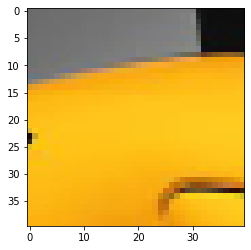

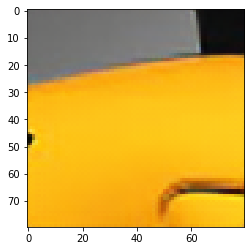

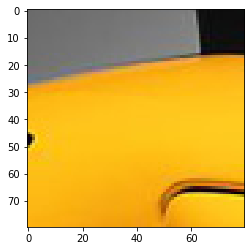

10051


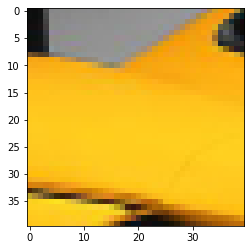

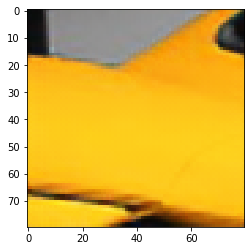

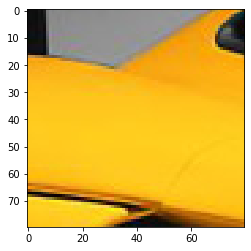

10052


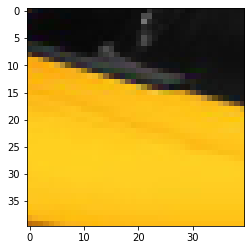

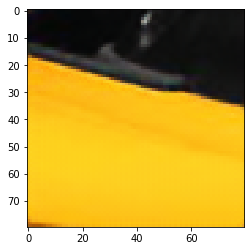

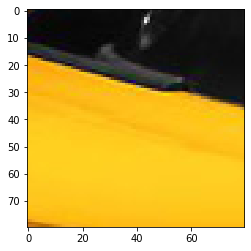

10053


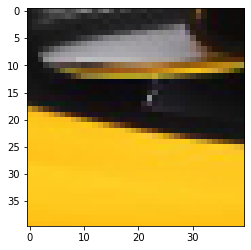

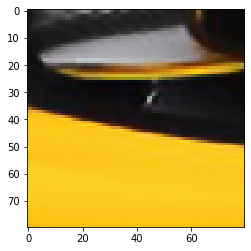

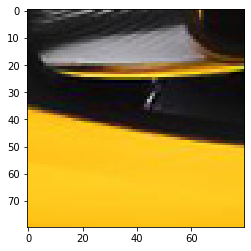

10054


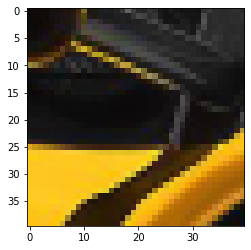

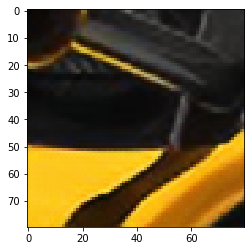

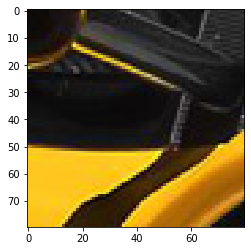

10055


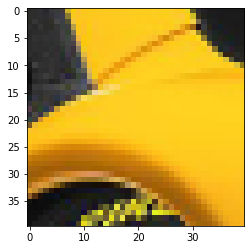

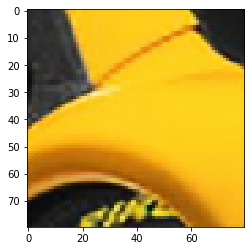

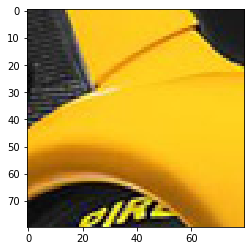

10056


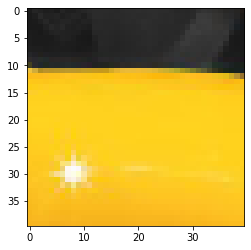

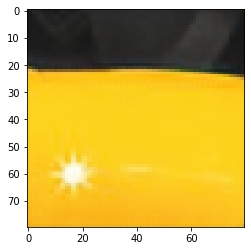

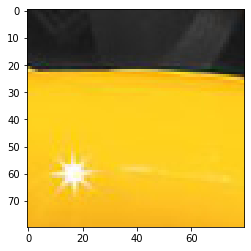

10057


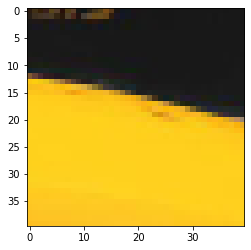

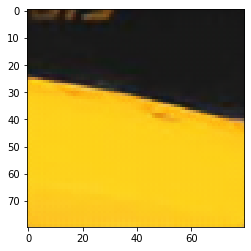

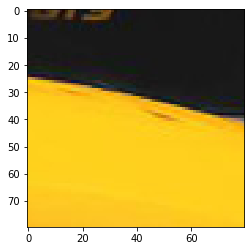

10058


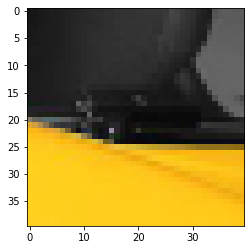

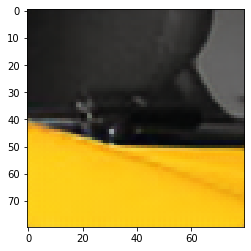

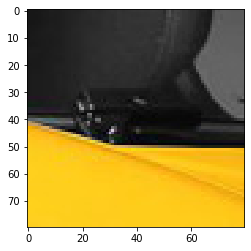

10059


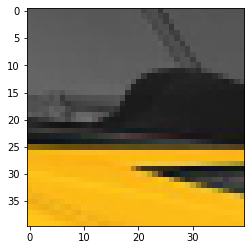

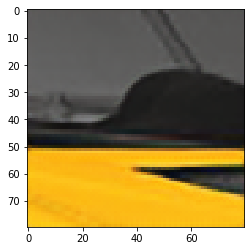

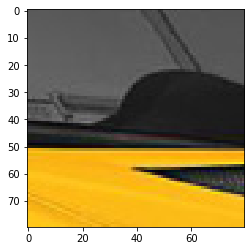

10060


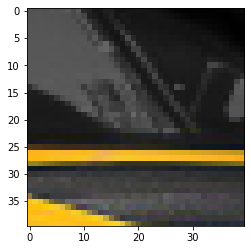

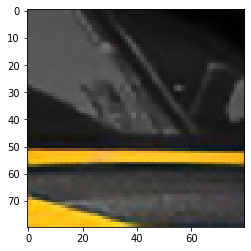

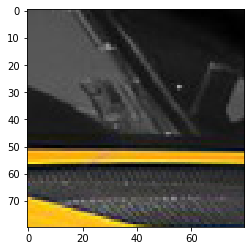

10061


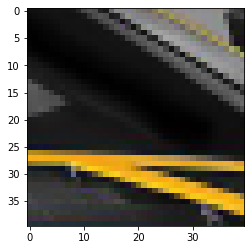

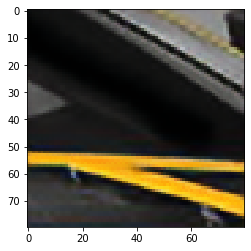

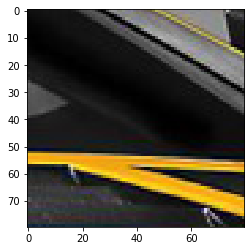

10062


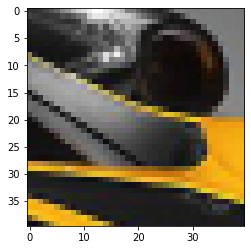

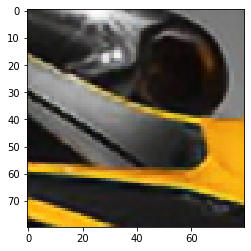

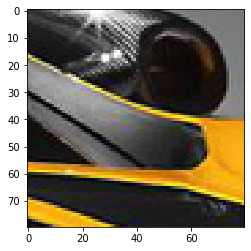

10063


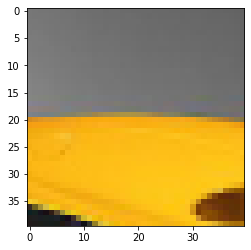

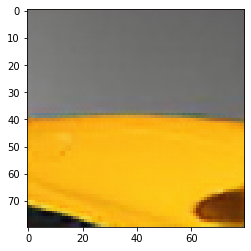

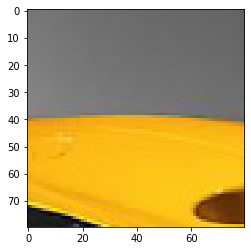

10064


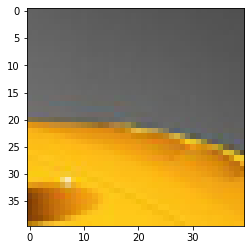

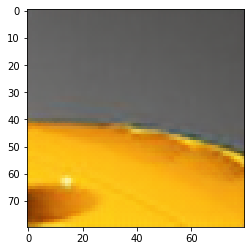

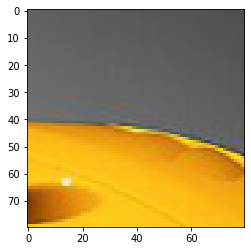

10065


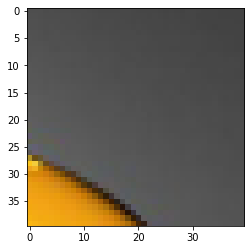

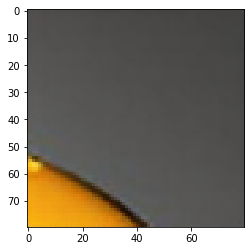

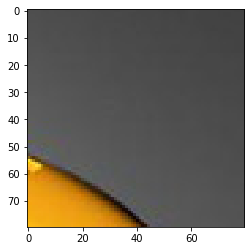

10066


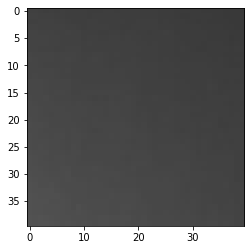

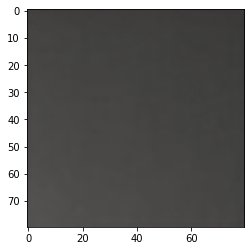

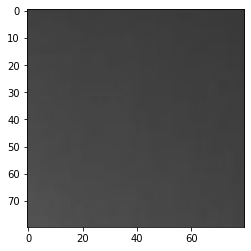

10067


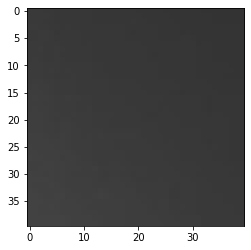

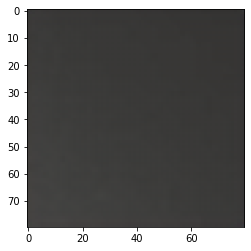

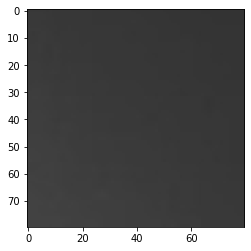

10068


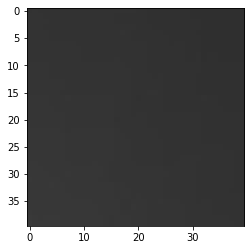

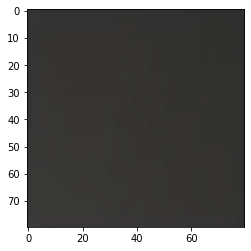

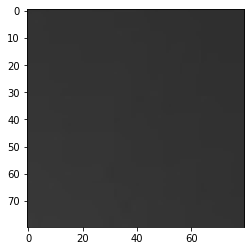

10069


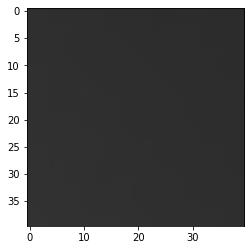

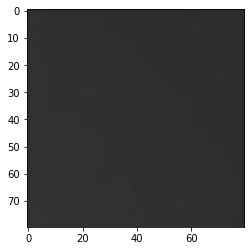

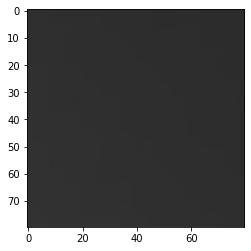

10070


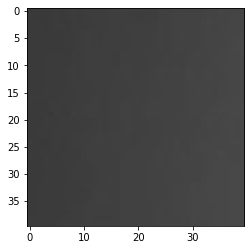

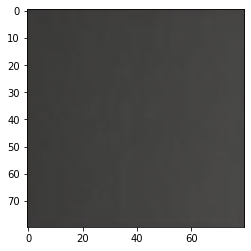

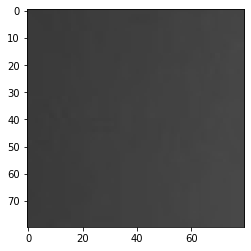

10071


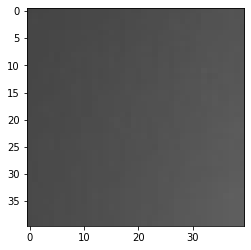

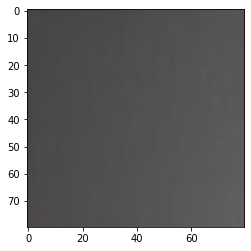

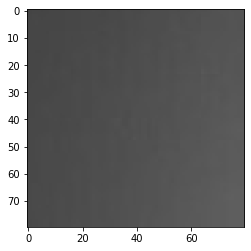

10072


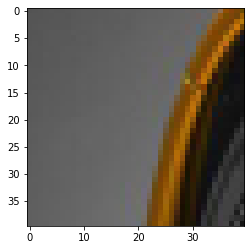

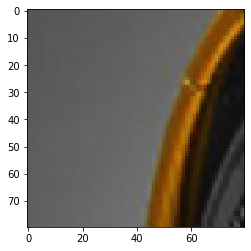

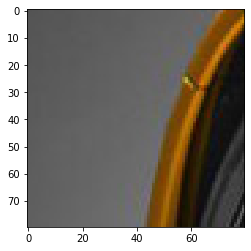

10073


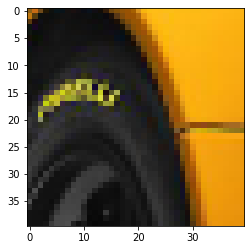

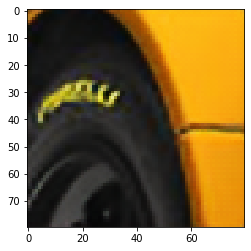

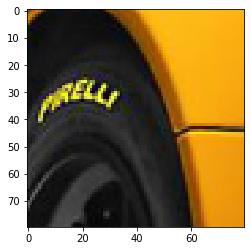

10074


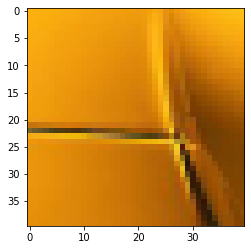

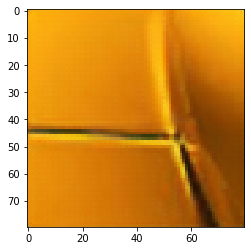

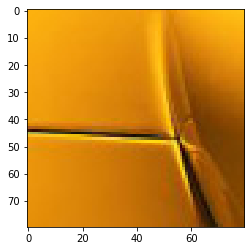

10075


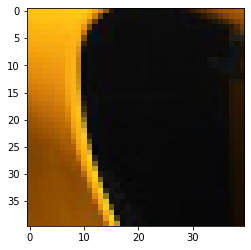

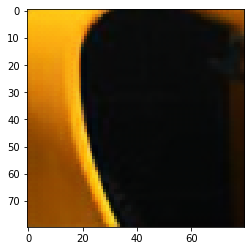

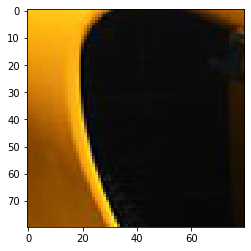

10076


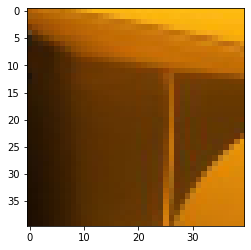

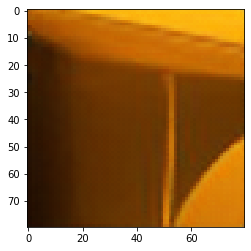

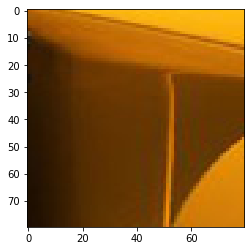

10077


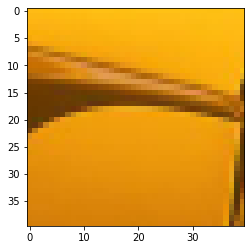

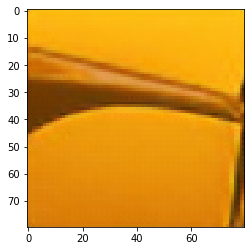

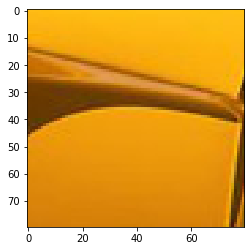

10078


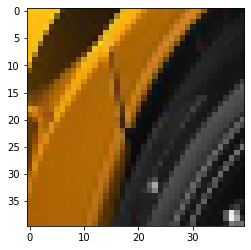

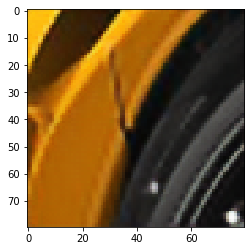

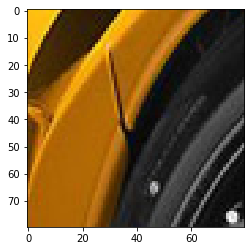

10079


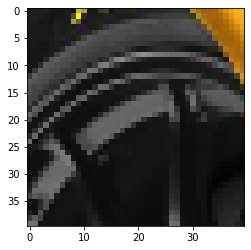

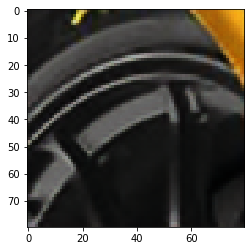

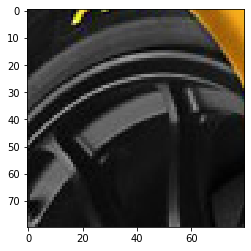

10080


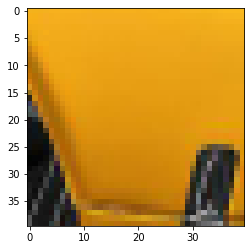

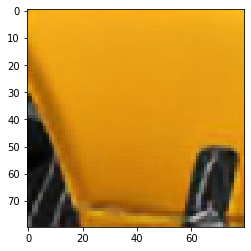

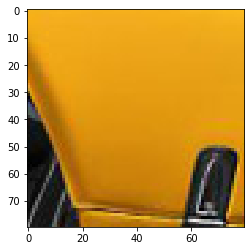

10081


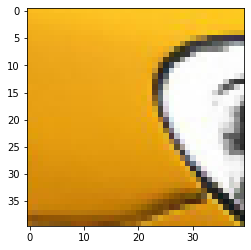

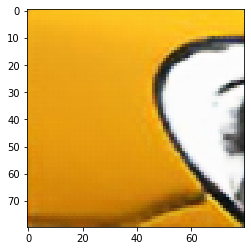

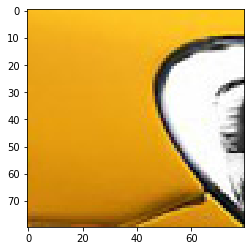

10082


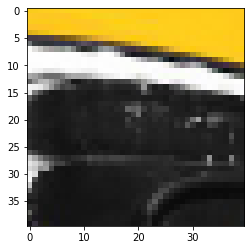

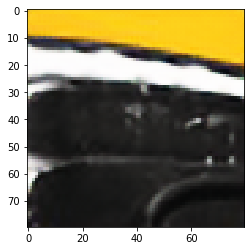

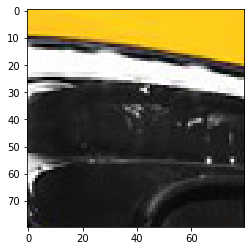

10083


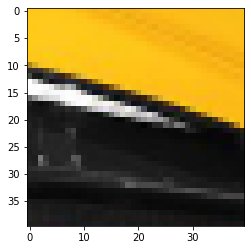

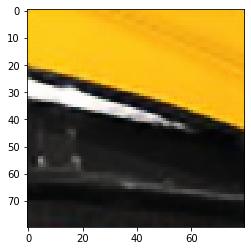

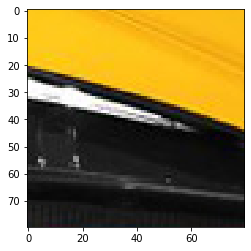

10084


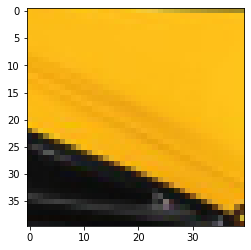

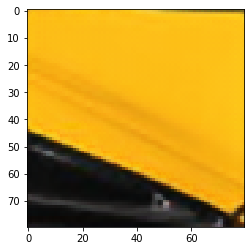

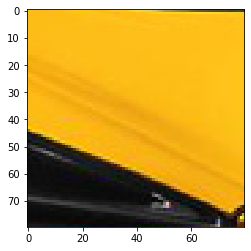

10085


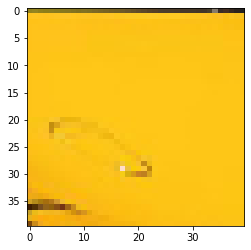

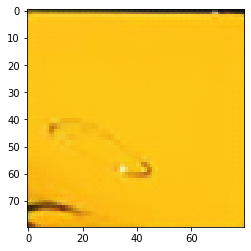

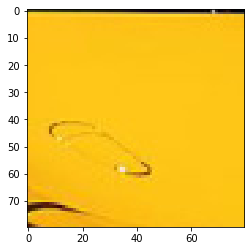

10086


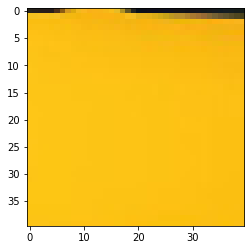

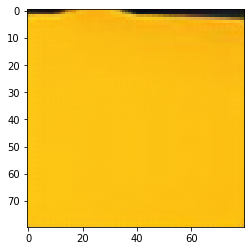

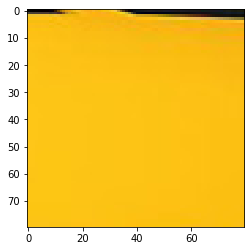

10087


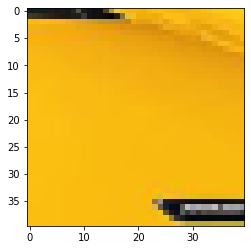

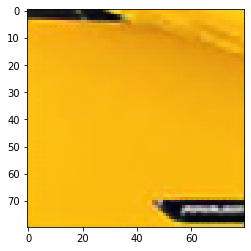

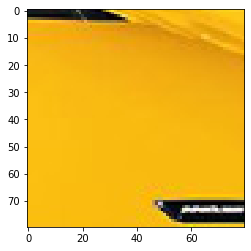

10088


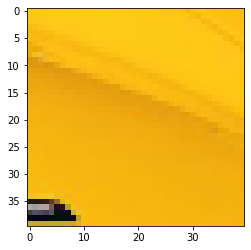

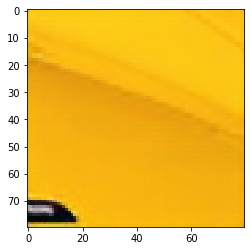

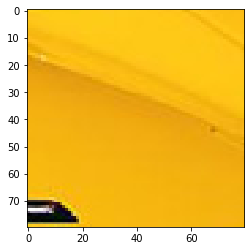

10089


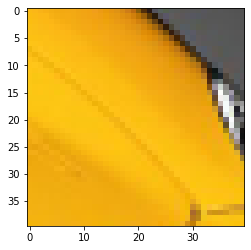

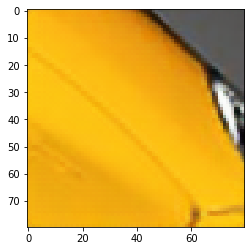

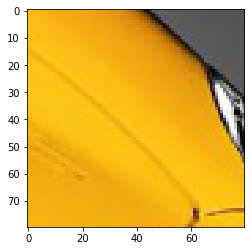

10090


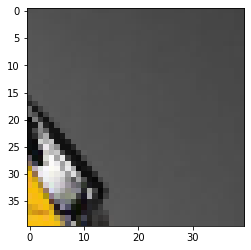

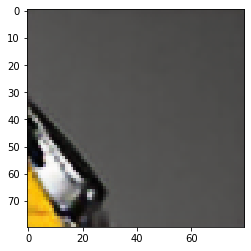

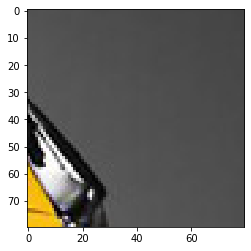

10091


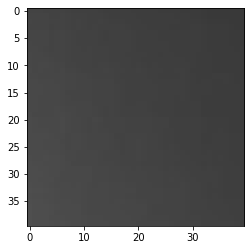

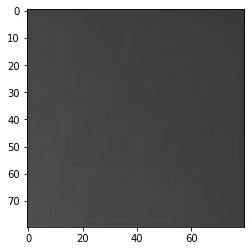

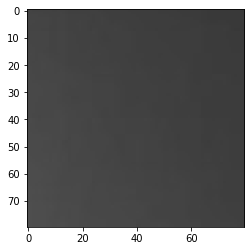

10092


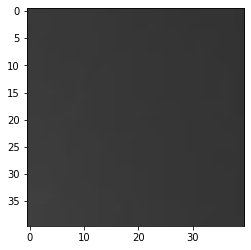

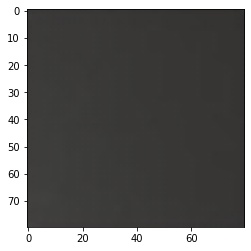

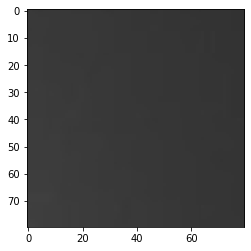

10093


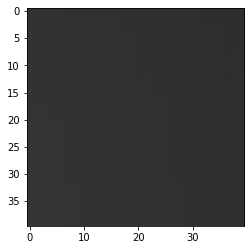

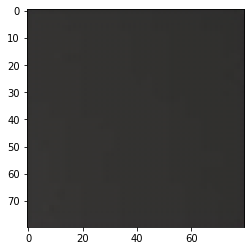

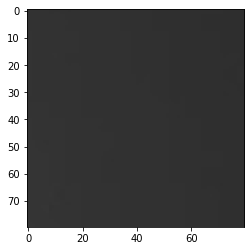

10094


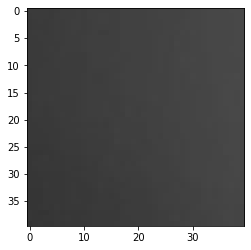

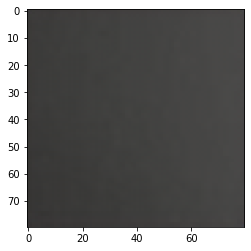

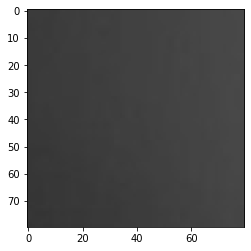

10095


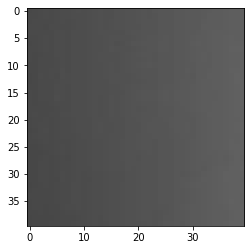

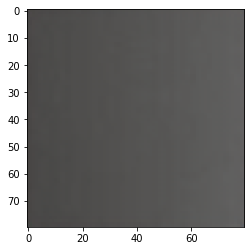

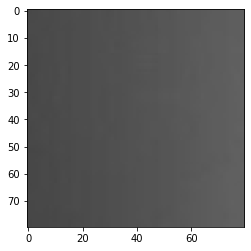

10096


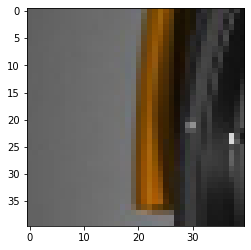

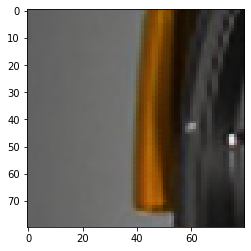

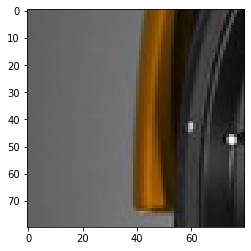

10097


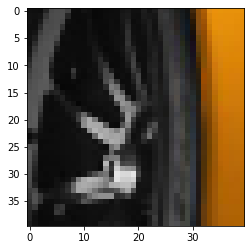

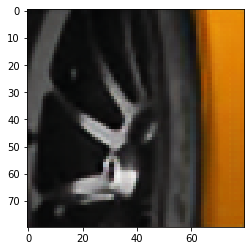

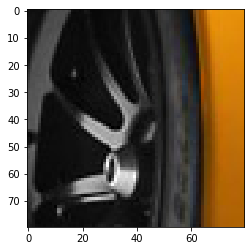

10098


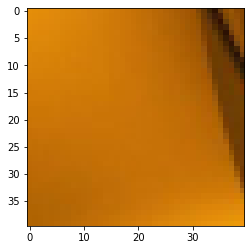

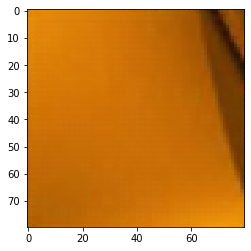

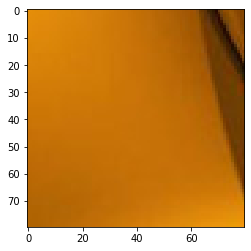

10099


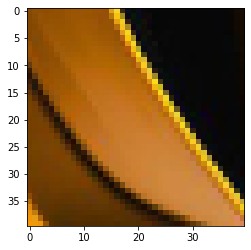

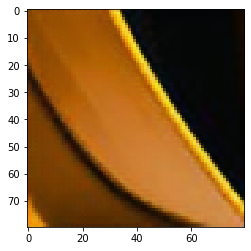

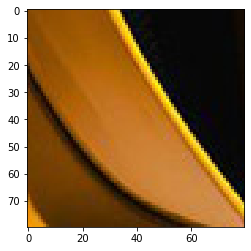

In [26]:
#check results first image is low res second is super resolutioned and final image is the original high res one(target)
start, end =10050,10100
yyy = lowres[start:end]
zzz = yyy /127.5 - 1.0
gen_imgs= superz.predict(zzz)
gen_imgs = 0.5 * gen_imgs + 0.5
j=0
for i in range(start,end):  
    print(i)
    plt.imshow(lowres[i])
    plt.show()
    plt.imshow(gen_imgs[j])
    j+=1
    plt.show()
    plt.imshow(highres[i])
    plt.show()
